In [3]:
#Boiler Plate for GPU Testing on Google Colab platform
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug 18 17:30:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

GPU Func Test, If Not Connected to a GPU is displayed then the GPU is not detected, codes of dataset generation and training block will take a lot of time.

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Additional Memory

In [5]:
#import tensorflow as tf  #Not required if run on Colab
import numpy as np  #Importing the numpy library -  a general-purpose array-processing package
import os   #Importing Operating System Interface
import pathlib    
import skimage.io as io
import skimage.transform as tf
import skimage.exposure as ex
import skimage.color as color
import torch
import torch.optim as optim
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from tensorflow import keras
!pip install haroun==0.0.5 # Using Haroun (Pytorch Framework) Copyright (c) 2021 HAROUN RAOUAK "https://github.com/hraouak/haroun/blob/main/LICENSE"
from haroun import Data
from haroun import Model
from haroun.losses import RMSE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing required packages (Note: Imports are based on the requirement of the Google Colab environment that was used)
Haroun (Pytorch Framework) Copyright (c) 2021 HAROUN RAOUAK "https://github.com/hraouak/haroun/blob/main/LICENSE"

In [6]:
def flip(images, labels, axis):   #Block: Reversing the order of the image array while maintenaning the aspect ratio
    flipped_images = np.flip(images, axis)
    flipped_labels = labels
    return flipped_images,flipped_labels

def brightness(images, labels, gamma):  #Block: Adjusting Image attributes to increase clarity and enhance distinct features
    brightness_images =  np.array([ex.adjust_gamma(image, gamma ,gain=1.0) for image in images])
    brightness_labels = labels
    return brightness_images, brightness_labels


def data_augmentation(images, labels):
    # Data augmentation (flip_horizontal)
    flipped_y_images,flipped_y_labels = flip(images, labels, axis=2) #Flipping the image along 2 axis
    
    # Concatenate arrays
    images = np.concatenate([images, flipped_y_images])
    labels = np.concatenate([labels, flipped_y_labels])
    
    darken_images, darken_labels = brightness(images, labels, gamma=1.0) #Darkening the images
    brighten_images, brighten_labels = brightness(images, labels, gamma=0.5) #Brighting the images
    
    # Concatenate arrays
    images = np.concatenate([images, darken_images, brighten_images])
    labels = np.concatenate([labels, darken_labels, brighten_labels])
    
    return images, labels

In [7]:
def load_data(): #defining the dataset before it is imported
    path = pathlib.Path.cwd().parent /"content"/"drive"/"MyDrive"/"Colab Notebooks"
    path = path /"COVID-19_Radiography_Dataset" / "COVID-19_Radiography_Dataset"
    images = []     #images set declaration
    labels = []     #Labels class Declartion

    for directory in os.listdir(path):
        data_path = path / directory
        for im in os.listdir(data_path)[:]:
            image = io.imread(f"{data_path}/{im}")
            image = color.rgb2gray(image)
            image = tf.resize(image, (72, 72))  #Resizing the pictures
            images.append(image)      #Fitting Images in the declared set
            labels.append(directory)

    images = np.array(images)
    labels = np.array(labels)
    
    images, labels = data_augmentation(images, labels)

    return images, labels

#print(pathlib.Path.cwd().parent) #Root Test to ensure root declaration is correct

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  # This is added back by InteractiveShellApp.init_path()


Images shape: (127134, 72, 72) Labels shape: (127134, 4)


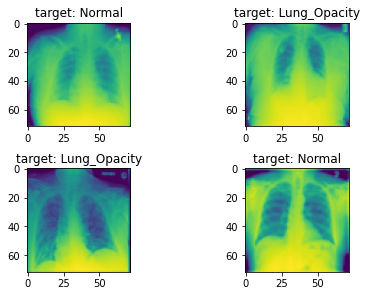

Train tensor shape: torch.Size([120777, 1, 72, 72]), torch.Size([120777, 4])
Test tensor shape: torch.Size([3178, 1, 72, 72]), torch.Size([3178, 4])
Validation tensor shape: torch.Size([3179, 1, 72, 72]), torch.Size([3179, 4])

Dataset generated successfully :)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   #Test to use GPU if available
classes = {'COVID': 0, 'Viral Pneumonia': 1,'Lung_Opacity': 2,'Normal': 3 } #Declaration of Classes of the Data

data = Data(loader=load_data(), classes=classes)
data.shape()
data.show()

data.dataset(split_size=0.05, shuffle=True, random_state=42,
             images_format=torch.float32, labels_format=torch.float32,
             permute=True, device=device) # Spliting Data into Trainng and Testing classes

In [9]:
# Setting up the neural network 
class conv_layer(torch.nn.Module):

    def __init__(cov, in_features, out_features):
        super(conv_layer, cov).__init__()
        cov.conv = torch.nn.Conv2d(in_features, out_features, kernel_size=3, stride=1, padding=1)
        cov.relu = torch.nn.ReLU()
        cov.norm = torch.nn.BatchNorm2d(out_features)
        cov.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(cov, X: torch.Tensor) -> torch.Tensor:
        X = cov.conv(X)
        X = cov.relu(X)
        X = cov.norm(X)
        X = cov.pool(X)
        return X


class Network(torch.nn.Module):

    def __init__(cov):
        super(Network, cov).__init__()
        cov.input_norm = torch.nn.BatchNorm2d(1, affine=False)
        cov.layer1 = conv_layer(in_features=1, out_features=8)
        cov.layer2 = conv_layer(in_features=8, out_features=16)
        cov.layer3 = conv_layer(in_features=16, out_features=32)
        cov.layer4 = conv_layer(in_features=32, out_features=64)
        cov.layer5 = conv_layer(in_features=64, out_features=128)
        cov.layer6 = conv_layer(in_features=128, out_features=256)
        
        

        cov.net = torch.nn.Sequential(cov.layer1, cov.layer2, cov.layer3, cov.layer4, cov.layer5, cov.layer6)
                                        
        
        cov.fc1 = torch.nn.Linear(in_features=256, out_features=128)
        cov.bn1 = torch.nn.BatchNorm1d(128)
        
        cov.fc2 = torch.nn.Linear(in_features=128, out_features=64)
        cov.bn2 = torch.nn.BatchNorm1d(64)

        cov.fc3 = torch.nn.Linear(in_features=64, out_features=32)
        cov.bn3 = torch.nn.BatchNorm1d(32)
        
        cov.fc4 = torch.nn.Linear(in_features=32, out_features=16)
        cov.bn4 = torch.nn.BatchNorm1d(16)

        cov.fc5 = torch.nn.Linear(in_features=16, out_features=4)


        cov.lin = torch.nn.Sequential(cov.fc1, cov.bn1, cov.fc2, cov.bn2, cov.fc3, cov.bn3, cov.fc4, cov.bn4, cov.fc5)

    def forward(cov, X: torch.Tensor) -> torch.Tensor:
        X = cov.input_norm(X)
        X = cov.net(X)
        X = X.reshape(X.size(0), -1)
        X = cov.lin(X)
        X = torch.nn.functional.elu(X, alpha=1.0, inplace=False)    
        return X

In [10]:
from datetime import datetime
start = datetime.now()

net = Network()
optimizer = optim.Adam(net.parameters(), lr=1.0E-3)   #Defining the learning optimizer 

ClassifyChestXray = Model(net, optimizer, RMSE, device)
ClassifyChestXray.train(train_data=(data.train_inputs, data.train_outputs),
                       val_data=(data.val_inputs, data.val_outputs),
                       epochs=130, patience=15, batch_size=200)
print (net.layer1, net.layer2, net.layer3, net.layer4, net.layer5, net.layer6)

duration=datetime.now() - start
print ("Total Training Time: ", duration )

Model initialized succssefully :)

Train loop:

	Epoch: 1/130,  Epoch duration: 35.5s,  Train Loss: 0.0361,  Val Loss: 0.0306
	Epoch: 2/130,  Epoch duration: 27.9s,  Train Loss: 0.0269,  Val Loss: 0.0251
	Epoch: 3/130,  Epoch duration: 27.8s,  Train Loss: 0.0234,  Val Loss: 0.0234
	Epoch: 4/130,  Epoch duration: 27.7s,  Train Loss: 0.0209,  Val Loss: 0.0218
	Epoch: 5/130,  Epoch duration: 27.7s,  Train Loss: 0.0188,  Val Loss: 0.0219 - No improvement -> Remaining patience: 14
	Epoch: 6/130,  Epoch duration: 27.8s,  Train Loss: 0.0169,  Val Loss: 0.0194
	Epoch: 7/130,  Epoch duration: 27.8s,  Train Loss: 0.0152,  Val Loss: 0.0178
	Epoch: 8/130,  Epoch duration: 27.7s,  Train Loss: 0.0139,  Val Loss: 0.0153
	Epoch: 9/130,  Epoch duration: 27.7s,  Train Loss: 0.0126,  Val Loss: 0.0177 - No improvement -> Remaining patience: 14
	Epoch: 10/130,  Epoch duration: 27.8s,  Train Loss: 0.0119,  Val Loss: 0.0156 - No improvement -> Remaining patience: 13
	Epoch: 11/130,  Epoch duration: 27.8s,  T

Training the CNN

In [11]:
ClassifyChestXray.evaluate(test_data=(data.test_inputs, data.test_outputs))


Test accuracy:99.3%
Correct predictions: 3155, Wrong predictions: 23


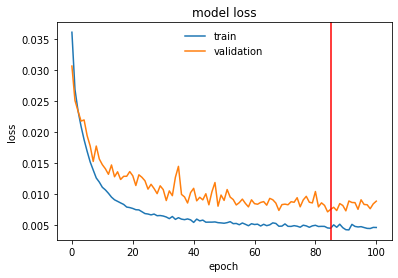

In [12]:
ClassifyChestXray.plot()

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_pred=[3170,3178], y_true=[3170, 3178])
print(f"accuracy:{acc}")


from sklearn import metrics
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_pred=[3170,3178], y_true=[3170, 3178])
sns.heatmap(cm, cmap="Greens", annot=True, cbar_kws={"label":"colour bar"},
            xticklabels=[0,1], yticklabels=[0,1])
plt.show()

Export Model file for intergration to the web application in .pth format

In [ ]:
ClassifyChestXray.save('/content/drive/MyDrive/Colab Notebooks', 'CNNXray')
print ("Model Saved")

Export nyp file for intergration to the web application

In [ ]:
np.save('CNNArrLabel.npy', classes)